# Filtering on a tripole grid

In this tutorial, we will use **Laplacians of varying complexity** to filter **tracer fields** on a global tripole grid ([Murray, 1996](https://www.sciencedirect.com/science/article/pii/S0021999196901369)). Examples of ocean models that use tripole grids include **POP** or **MOM6**.

In [1]:
import gcm_filters
import numpy as np
import xarray as xr

The following are the grid types that we have so far implemented in `gcm-filters`:

In [2]:
list(gcm_filters.GridType)

[<GridType.REGULAR: 1>,
 <GridType.REGULAR_WITH_LAND: 2>,
 <GridType.IRREGULAR_WITH_LAND: 3>,
 <GridType.TRIPOLAR_REGULAR_WITH_LAND: 4>,
 <GridType.TRIPOLAR_POP_WITH_LAND: 5>]

For each of these grid types, we have implemented a Laplacian that operates on the respective grid type. In this notebook, we will apply 4 Laplacians to filter **tracer fields on a global tripole grid**. 

| Laplacian | simple fixed factor  | fixed filter length scale|
| ----------- | ----------- | --------------|
| Ignores tripolar exchanges  | `REGULAR_WITH_LAND`       | `IRREGULAR_WITH_LAND` |
| Handles tripolar exchanges  | `TRIPOLAR_REGULAR_WITH_LAND`        | `TRIPOLAR_POP_WITH_LAND` |

As shown in the table, the categories in which the 4 Laplacians differ are:
* **complexity** (rows)
* **filter type** they can be used for (columns)

For details on different filter types, see [this tutorial](https://gcm-filters.readthedocs.io/en/latest/tutorial_filter_types.html).
In short:
* A filter with **fixed factor**, e.g., `factor = 10`, attempts to remove scales smaller than 10 times the local grid scale. 
* A filter with **fixed filter length scale**, e.g., `filter_scale = 100 km`, attempts to remove scales smaller than 100km. 

**Side note:** The Laplacians in the right column can also be used for fixed factor filtering (less ad hoc than the simple fixed factor filters), anisotropic filtering, and for filtering with spatially-varying filter scale, through the use of spatially-varying `kappa`'s, see the [Filter Theory](https://gcm-filters.readthedocs.io/en/latest/filter_theory.html) and [this tutorial](https://gcm-filters.readthedocs.io/en/latest/tutorial_filter_types.html). In summary, the Laplacians in the right column are more flexible than the Laplacians in the left column - but also more expensive. In this notebook, we use the Laplacians in the right column only for filtering with fixed filtering scale.

## Global POP data

First, we are going to work with the 0.1 degree nominal resolution POP tripole grid ([Smith et al., 2010](https://www.cesm.ucar.edu/models/cesm1.0/pop2/doc/sci/POPRefManual.pdf)). The grid variables are stored in the following dataset, which we pull from figshare.

In [3]:
import requests
url = 'https://ndownloader.figshare.com/files/28041441'
file = requests.get(url)
open('POP_tripole_grid.nc', 'wb').write(file.content)
ds = xr.open_dataset('POP_tripole_grid.nc')
ds

<xarray.Dataset>
Dimensions:  (nlat: 2400, nlon: 3600, time: 1, z_t: 62)
Coordinates:
  * time     (time) object 0033-11-27 00:00:00
  * z_t      (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.625e+05 5.875e+05
    ULONG    (nlat, nlon) float64 ...
    ULAT     (nlat, nlon) float64 ...
    TLONG    (nlat, nlon) float64 ...
    TLAT     (nlat, nlon) float64 ...
Dimensions without coordinates: nlat, nlon
Data variables:
    KMT      (nlat, nlon) float64 ...
    TAREA    (nlat, nlon) float64 ...
    HTN      (nlat, nlon) float64 ...
    HTE      (nlat, nlon) float64 ...
    HUS      (nlat, nlon) float64 ...
    HUW      (nlat, nlon) float64 ...
    SST      (time, nlat, nlon) float32 ...
Attributes:
    title:           g.e01.GIAF.T62_t12.003
    history:         none
    Conventions:     CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-curr...
    contents:        Diagnostic and Prognostic Variables
    source:          CCSM POP2, the CCSM Ocean Component
    revision:        $Id: tavg.F90 46405 2013-04-26 05:24:34Z mlevy@ucar.edu $
    calendar:        All years have exactly  365 days.
    start_time:      This dataset was created on 2014-07-19 at 17:28:03.3
    cell_methods:    cell_methods = time: mean ==> the variable values are av...
    nsteps_total:    9618241
    tavg_sum:        431999.9999999717
    tavg_sum_qflux:  432000.00000000006

### Preparing POP grid information

All Laplacians listed in our table need a `wet_mask`. This is a mask that is 1 in ocean T-cells, and 0 in land T-cells. Since we only want to filter temperature in the uppermost level, we only need a 2D `wet_mask`.

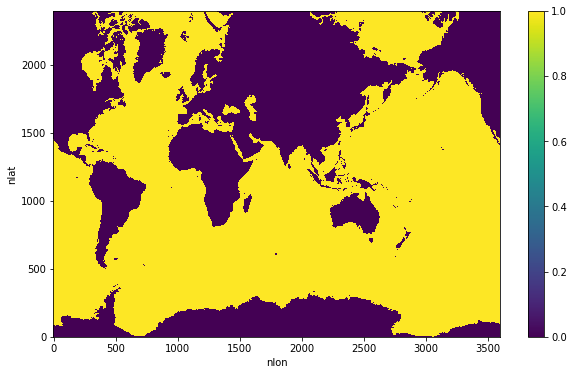

In [4]:
wet_mask = xr.where(ds['KMT']>0, 1, 0)
wet_mask.plot(figsize=(10,6), cbar_kwargs={'label': ''});

Let's start by creating the grid information for the `TRIPOLAR_POP_WITH_LAND` Laplacian. The required grid variables are directly available from POP's model diagnostics:

In [5]:
dxe = ds.HUS.where(wet_mask)/100  # x-spacing centered at eastern T-cell edge in m
dye = ds.HTE.where(wet_mask)/100  # y-spacing centered at eastern T-cell edge in m
dxn = ds.HTN.where(wet_mask)/100  # x-spacing centered at northern T-cell edge in m
dyn = ds.HUW.where(wet_mask)/100  # y-spacing centered at northern T-cell edge in m
area = ds.TAREA.where(wet_mask)/10000  # T-cell area in m2

The `IRREGULAR_WITH_LAND` Laplacian was coded for general curvilinear grids and uses a south-west convention (rather than a north-east convention). In other words, it needs grid length information about the western and southern cell edges: `dxw`, `dyw`, `dxs`, `dys`.

In [6]:
dxw = ds.HUS.roll(nlon=-1, roll_coords=False).where(wet_mask)/100  # x-spacing centered at western T-cell edge in m
dyw = ds.HTE.roll(nlon=-1, roll_coords=False).where(wet_mask)/100  # y-spacing centered at western T-cell edge in m
dxs = ds.HTN.roll(nlat=-1, roll_coords=False).where(wet_mask)/100  # x-spacing centered at southern T-cell edge in m
dys = ds.HUW.roll(nlat=-1, roll_coords=False).where(wet_mask)/100  # y-spacing centered at southern T-cell edge in m

Finally, the filters with fixed filter length scale will have to know what the minimum grid spacing is in our model.

In [7]:
dx_min_POP = min(dxe.min(),dye.min(),dxn.min(),dyn.min())
dx_min_POP = dx_min_POP.values
dx_min_POP

array(2245.78304344)

### Field to be filtered

Usually, fields that we would want to filter on a tripole grid are fields from model output (from a model with native tripole grid), e.g., temperature, salinity, kinetic energy. Here, we instead filter a very simple field: the sum of two **delta functions**, $\delta = \delta_1 - \delta_2$, where $\delta_1$ and $\delta_2$ have **mass close to the northern boundary fold** of the logical POP tripole grid. This choice will make the difference between the different Laplacians in our table above extra clear.

In [8]:
delta1 = 0 * xr.ones_like(ds.nlat * ds.nlon)  # initialize 2D field with zeros
delta2 = 0 * xr.ones_like(ds.nlat * ds.nlon)  # initialize 2D field with zeros
delta1[2399, 900:950] = 1  # deploy mass in the uppermost row; width: 50 columns
delta2[2399,2500:2550] = 1  # deploy mass in the uppermost row; width: 50 columns
delta = delta1 - delta2
delta = delta.where(wet_mask)

Here we plot the **uppermost 20 rows of the logical POP tripole grid**, a **subset of the distorted Arctic** (even if this is hard to see with this projection).

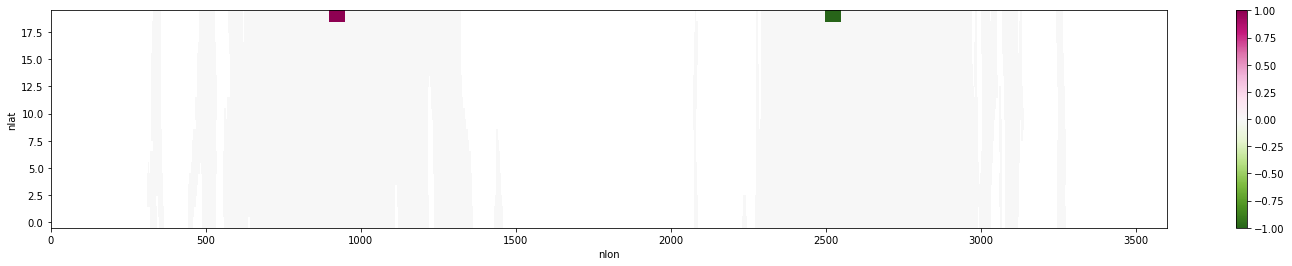

In [9]:
yslice = slice(len(ds.nlat)-20, None)
delta.isel(nlat=yslice).plot(figsize=(25,4), cmap='PiYG_r')

In the model, there are exchanges across the northern edge of the logical array plotted above. The exchanges work as follows: You fold the northern edge onto itself, rotating it along a pivot point that is located in the middle of the northern edge.
The point is that **Laplacians that handle tripolar exchanges** (second row in table above) will diffuse the two delta functions **across the northern edge**, into the respective other half of the domain.

### Simple fixed factor filters

First, we create the two filters with **fixed factor** (left column in table above). In both cases, we choose a **fixed factor of 10** and a **Gaussian filter shape**.

In [10]:
factor = 10
dx_min = 1
filter_shape = gcm_filters.FilterShape.GAUSSIAN

In [11]:
filter_regular_with_land = gcm_filters.Filter(
    filter_scale=factor,
    dx_min=dx_min,
    filter_shape=filter_shape,
    grid_type=gcm_filters.GridType.REGULAR_WITH_LAND,
    grid_vars={'wet_mask': wet_mask}
)
filter_regular_with_land

Filter(filter_scale=10, dx_min=1, filter_shape=<FilterShape.GAUSSIAN: 1>, transition_width=3.141592653589793, ndim=2, n_steps=11, grid_type=<GridType.REGULAR_WITH_LAND: 2>)

In [12]:
filter_tripolar_regular_with_land = gcm_filters.Filter(
    filter_scale=factor,
    dx_min=1,
    filter_shape=filter_shape,
    grid_type=gcm_filters.GridType.TRIPOLAR_REGULAR_WITH_LAND,
    grid_vars={'wet_mask': wet_mask}
)
filter_tripolar_regular_with_land

Filter(filter_scale=10, dx_min=1, filter_shape=<FilterShape.GAUSSIAN: 1>, transition_width=3.141592653589793, ndim=2, n_steps=11, grid_type=<GridType.TRIPOLAR_REGULAR_WITH_LAND: 4>)

In [13]:
%time delta_filtered_regular_with_land = filter_regular_with_land.apply(delta*area, dims=['nlat', 'nlon'])/area
%time delta_filtered_tripolar_regular_with_land = filter_tripolar_regular_with_land.apply(delta*area, dims=['nlat', 'nlon'])/area

CPU times: user 3.56 s, sys: 4.02 s, total: 7.58 s
Wall time: 7.6 s
CPU times: user 3.84 s, sys: 4.77 s, total: 8.61 s
Wall time: 8.68 s


Filtering with the second filter took a touch longer than with the first filter because the second filter is of increased complexity: it handles the tripolar boundary condition correctly, whereas the first filter does not. This is shown in the figure below.

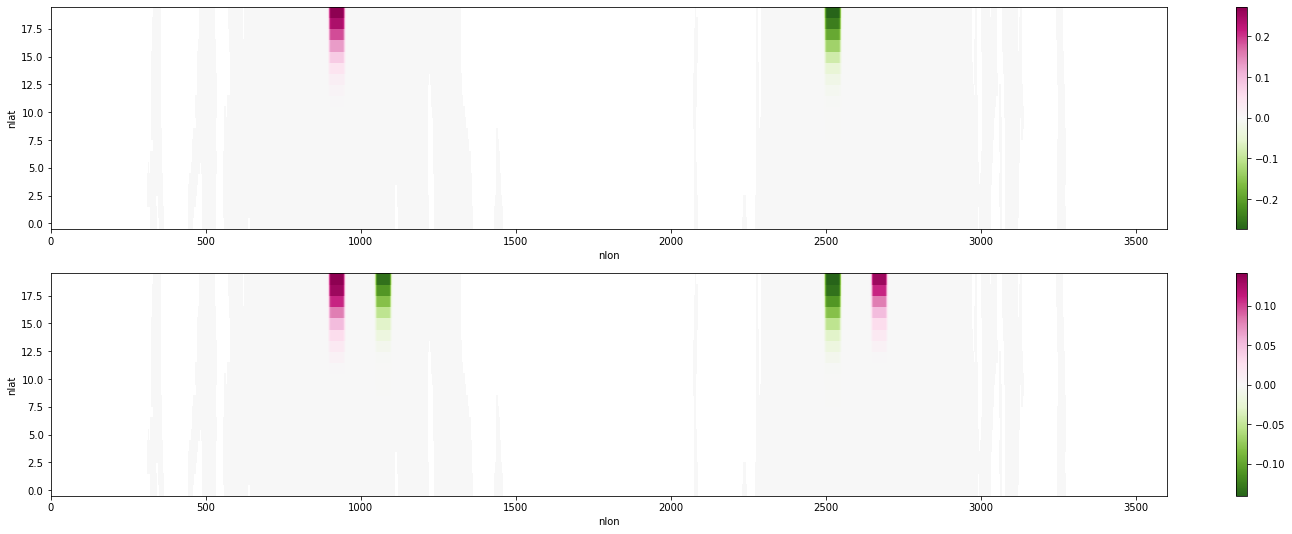

In [14]:
import matplotlib.pyplot as plt

fig,axs = plt.subplots(2,1,figsize=(25,9))
delta_filtered_regular_with_land.isel(nlat=yslice).plot(ax=axs[0], cmap='PiYG_r')
delta_filtered_tripolar_regular_with_land.isel(nlat=yslice).plot(ax=axs[1], cmap='PiYG_r');

The **second panel** confirms that the `TRIPOLAR_REGULAR_WITH_LAND` Laplacian allows exchanges across the northern boundary fold, both 
* from left to right (pink shading, originating from `delta1` deployed in left part of domain); and 
* from right to left (green shading, originating from `delta2` deployed in right part of domain). 

The **first panel** shows that the `REGULAR_WITH_LAND` Laplacian does not allow exchanges across the northern boundary fold as expected. Also note that the amplitudes of the diffused delta functions in panel 1 are higher than in panel 2. This is due to the fact that `IRREGULAR_WITH_LAND` thinks that the northern boundary is land (because the southernmost row of `wet_mask` consists of zeros: Antarctica, and `IRREGULAR_WITH_LAND` uses a periodic boundary condition). The effective kernel changes shape close to the continental boundaries; loosely speaking, the effective kernel reflects back into the ocean if it hits continental boundaries.

### Filters with fixed filter length scale

The next two filters are for filtering with **fixed length scale** (right column in table above). For both filters, we pick a filter length scale of **111.7 km**, equal to one degree of latitude.

In [15]:
filter_scale = 111700 
filter_shape = gcm_filters.FilterShape.GAUSSIAN
dx_min = dx_min_POP

In [16]:
filter_irregular_with_land = gcm_filters.Filter(
    filter_scale=filter_scale,
    dx_min=dx_min,
    filter_shape=filter_shape,
    grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
    grid_vars={
        'wet_mask': wet_mask, 
        'dxw': dxw, 'dyw': dyw, 'dxs': dxs, 'dys': dys, 'area': area
    }
)
filter_irregular_with_land

Filter(filter_scale=111700, dx_min=array(2245.78304344), filter_shape=<FilterShape.GAUSSIAN: 1>, transition_width=3.141592653589793, ndim=2, n_steps=55, grid_type=<GridType.IRREGULAR_WITH_LAND: 3>)

In [17]:
filter_tripolar_pop_with_land = gcm_filters.Filter(
    filter_scale=filter_scale,
    dx_min=dx_min,
    filter_shape=filter_shape,
    grid_type=gcm_filters.GridType.TRIPOLAR_POP_WITH_LAND,
    grid_vars={
        'wet_mask': wet_mask, 
        'dxe': dxe, 'dye': dye, 'dxn': dxn, 'dyn': dyn, 'tarea': area
    }
)
filter_tripolar_pop_with_land

Filter(filter_scale=111700, dx_min=array(2245.78304344), filter_shape=<FilterShape.GAUSSIAN: 1>, transition_width=3.141592653589793, ndim=2, n_steps=55, grid_type=<GridType.TRIPOLAR_POP_WITH_LAND: 5>)

In [18]:
%time delta_filtered_irregular_with_land = filter_irregular_with_land.apply(delta, dims=['nlat', 'nlon'])
%time delta_filtered_tripolar_pop_with_land = filter_tripolar_pop_with_land.apply(delta, dims=['nlat', 'nlon'])

CPU times: user 17.6 s, sys: 19 s, total: 36.6 s
Wall time: 36.7 s
CPU times: user 18.7 s, sys: 18.4 s, total: 37.1 s
Wall time: 37.3 s


Both filters took considerably longer than the simple fixed factor filters in the previous section, as expected. Again, filtering with the second filter took a touch longer than with the first filter (but not too much longer), due to the correct handling of the tripolar boundary exchanges.

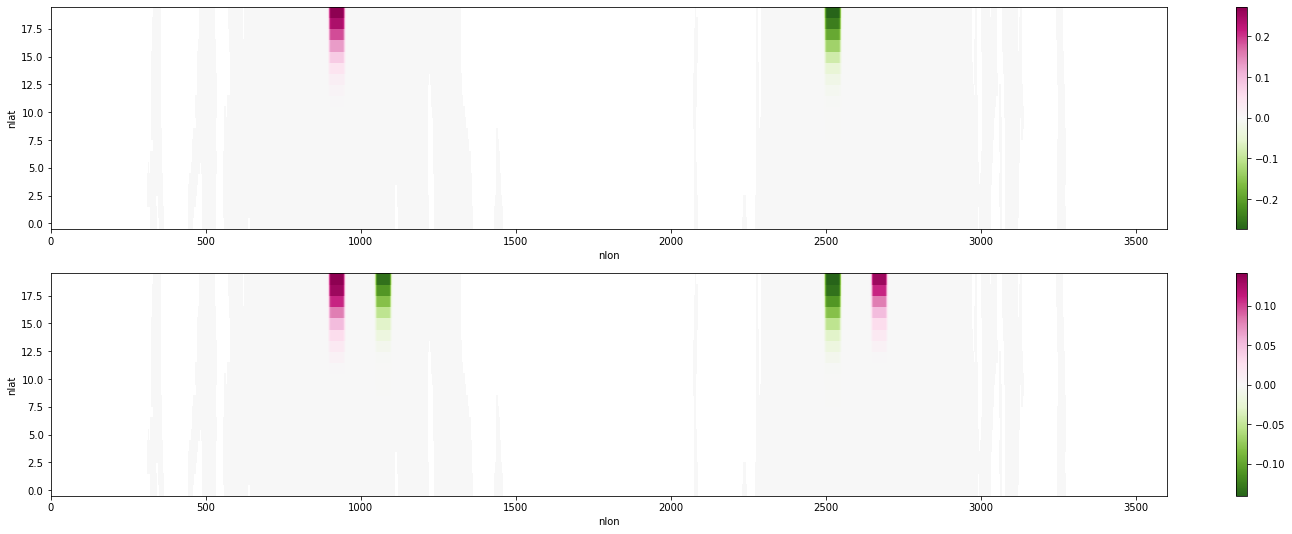

In [19]:
fig,axs = plt.subplots(2,1,figsize=(25,9))
delta_filtered_regular_with_land.isel(nlat=yslice).plot(ax=axs[0], cmap='PiYG_r')
delta_filtered_tripolar_regular_with_land.isel(nlat=yslice).plot(ax=axs[1], cmap='PiYG_r');

## Global MOM6 data
...